## Given the speech segment (aa.wav) extracted from the word “pani” in  “machali.wav” (male voice), sampled at 8 kHz, do the following.  Report/discuss your observations at each step. 

#### Loading the audio `machali.wav`

In [1]:
!pip install control

     |████████████████████████████████| 339 kB 7.7 MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344928 sha256=08648a1a3644f7c44be22e0a48cb0c4696755767221c0e909d8ffbbb17e9dbef
  Stored in directory: /root/.cache/pip/wheels/5b/64/54/70faad181d7baff1184541ca00c9a2efa633acd0a811831d30
Successfully built control


In [26]:
# Importing libraries
import numpy as np
import IPython
import control
from scipy.io.wavfile import read, write
import matplotlib.pyplot as plt
import cmath

filename = '/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 3/aa.wav'

# Reading the audio
fs, data = read(filename)

# Playing the audio
IPython.display.Audio(filename)

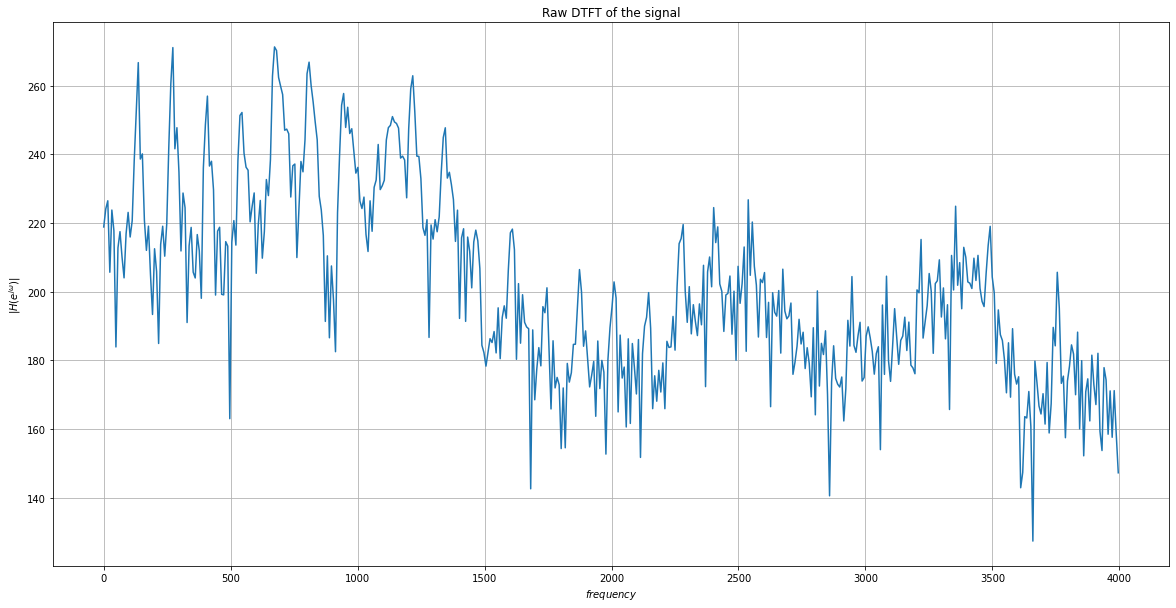

In [27]:
# Plotting the magnitude spectrum in dB after computing the dft

H_ejw = np.fft.fft(data, 1000) # COmputing 1000 point DFT for better resolution.
mag_H_ejw = list(map(abs,H_ejw))

omega = np.linspace(0,8000, 1000)

plt.figure(figsize= (20,10))
plt.plot(omega[0:500], 20*np.log(mag_H_ejw)[0:500])
plt.xlabel('$frequency$')
plt.ylabel('$|H(e^{j\omega})|$')
plt.title('Raw DTFT of the signal')
plt.grid()

### 1. Apply pre-emphasis to the signal.

In [28]:
# from the equation of P(z) = 1-(alpha)*(z^(-1)) which will be used for applying pre-emphasis, has the following parameters
# Numerator Coefficeints: [1, 1]
# Denominator Coeffficients: [1]
import scipy.signal as sig
alpha = 0.95
a = [1.0, -alpha]
b = [1.0]

audio_pre_emph = sig.lfilter(a,b,data)

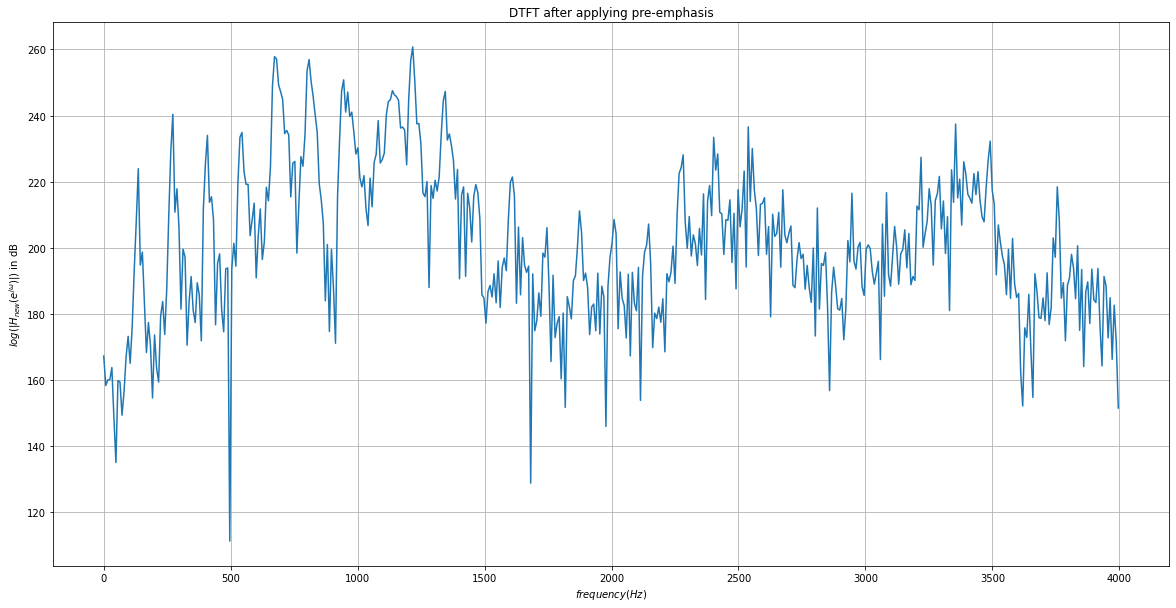

In [29]:
H_new_ejw = np.fft.fft(audio_pre_emph, 1000) # Computing 1000 point DFT for better resolution

mag_H_new_ejw = list(map(abs, H_new_ejw))

# Plotting the modified spectrum in dB

plt.figure(figsize= (20,10))
plt.plot(omega[0:500], 20*np.log(mag_H_new_ejw)[0:500])
plt.xlabel('$frequency (Hz)$')
plt.ylabel('$log(|H_{new}(e^{j\omega})|)$ in dB')
plt.title('DTFT after applying pre-emphasis')
plt.grid()

### 2. Compute and plot the narrowband magnitude spectrum slice using a Hamming window of duration = 30 ms on a segment near the centre of the given audio file. 

In [30]:
def hamming(M):
  n = np.linspace(0,M,M)
  out = 0.54 - 0.46*np.cos(2*np.pi*n/(M-1))
  return out

In [31]:
# 30ms with 8kHz sampling rate correspond to 240 samples
signal_slice = audio_pre_emph[360-120:360+120]

# Hamming window of desired length
hamming_window = hamming(240)

# Output of hamming window
windowed_signal = signal_slice*hamming_window

In [32]:
windowed_sig_filename = '/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 3/windowed.wav'

write(windowed_sig_filename, 8000, windowed_signal.astype('int16'))

# Reading the audio
fs, data = read(windowed_sig_filename)

# Playing the audio
IPython.display.Audio(windowed_sig_filename)

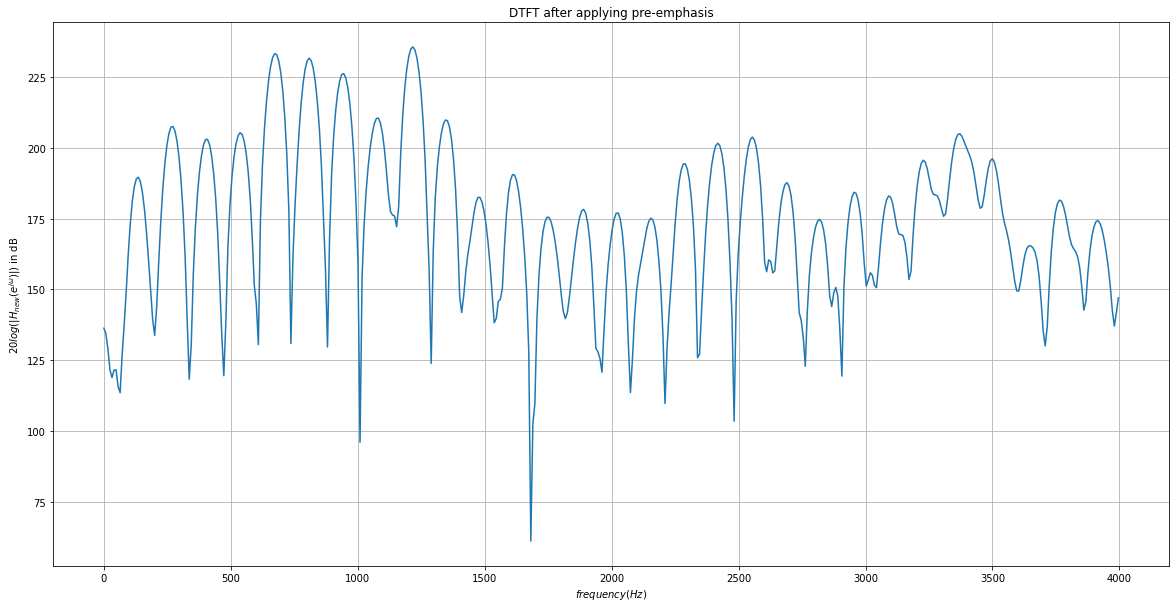

In [33]:
# PLotting the narrowband spectrum slice
win_sig_spectrum = np.fft.fft(windowed_signal, 1000) # Computing 1000 point DFT for better resolution
mag_win_sig_spectrum = list(map(abs,win_sig_spectrum)) # Getting the magnitude spectrum

frequency = np.linspace(0,8000, 1000)

plt.figure(figsize= (20,10))
plt.plot(frequency[0:500], 20*np.log(mag_win_sig_spectrum[0:500]))
plt.xlabel('$frequency (Hz)$')
plt.ylabel('$20log(|H_{new}(e^{j\omega})|)$ in dB')
plt.title('DTFT after applying pre-emphasis')
plt.grid()

### 3. With the same 30 ms segment of part 2, compute the autocorrelation coefficients required for LPC calculation at various p = 2,4,6,8,10.  Use the Levinson-Durbin recursion to compute the LP coefficients from the autocorrelation coefficients. Plot error signal energy (i.e. square of gain) vs p.

#### Defining helper functions

In [34]:
def autocorrelation(k, x):
  k = abs(k)
  x_shifted = np.zeros_like(x)
  x_shifted[0:len(x_shifted) - k] = x[k:len(x)]
  output = np.dot(x_shifted, x)
  return output

In [35]:
# Levinson Durbin

# Code @Author: Shashwat Pathak (213070010)

'''
This implementation gives all the coefficients obtained in the previous steps
along with the error obtained after each step.
'''


def levinson_durbin(input,p):
  # Error at step 0
  error = np.zeros(p+1)
  error[0] = autocorrelation(0,input)

  # Initializing the coefficient matrix 
  a = np.zeros((p+1,p+1))

  ## Step 1
  # Computing the first reflection coefficient
  k = autocorrelation(1,input)/error[0]
  a[1][1]= k
  error[1] = (1 - k**2)*error[0]

  # iterating for next steps
  for i in range(2,p+1):
    sum = 0
    for j in range(1,i):
      sum = sum + a[i-1][j]*autocorrelation(i-j, input)

    k = (autocorrelation(i,input) - sum)/error[i-1]
    a[i][i] = k
    for j in range(1,i):
      a[i][j] = a[i-1][j] - k*a[i-1][i-j]

      error[i] = (1 - k**2)*error[i-1]
  return a[1:,1:], error[1:]

#### Obtaining the LP Coefficients and Error Signal

In [45]:
# This step will give us the error coefficients for all the steps at every p
coeffs, errors = levinson_durbin(windowed_signal,10)

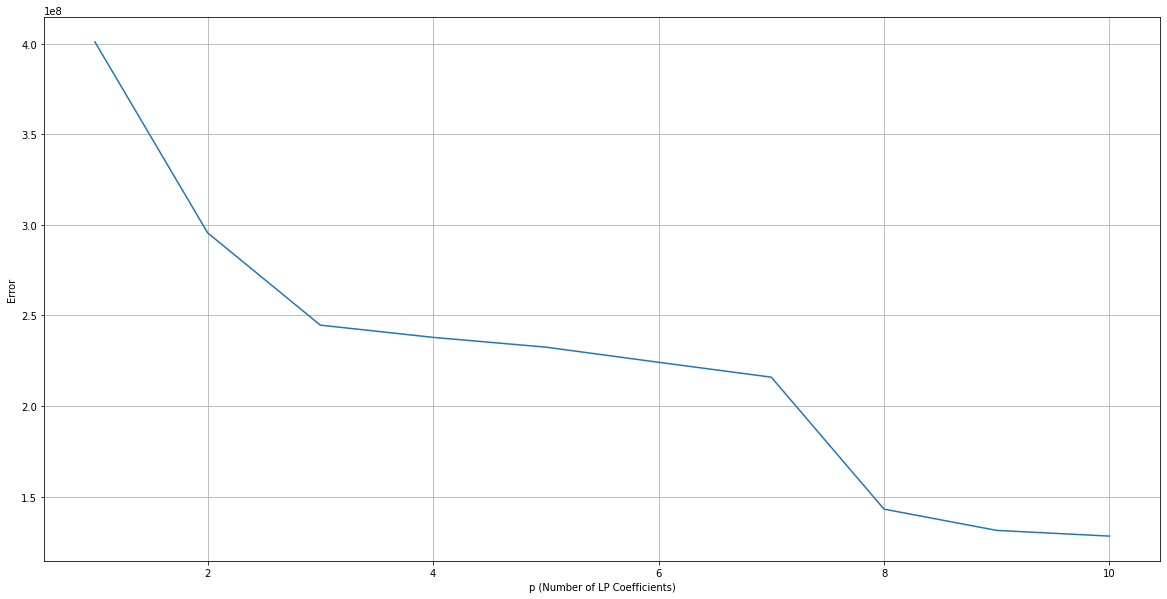

In [46]:
# Plotting all the errors wrt to p
p = np.linspace(1,10,10)
plt.figure(figsize=(20,10))
plt.plot(p,errors)
plt.xlabel('p (Number of LP Coefficients)')
plt.ylabel('Error')
plt.grid()

Text(0, 0.5, 'Error')

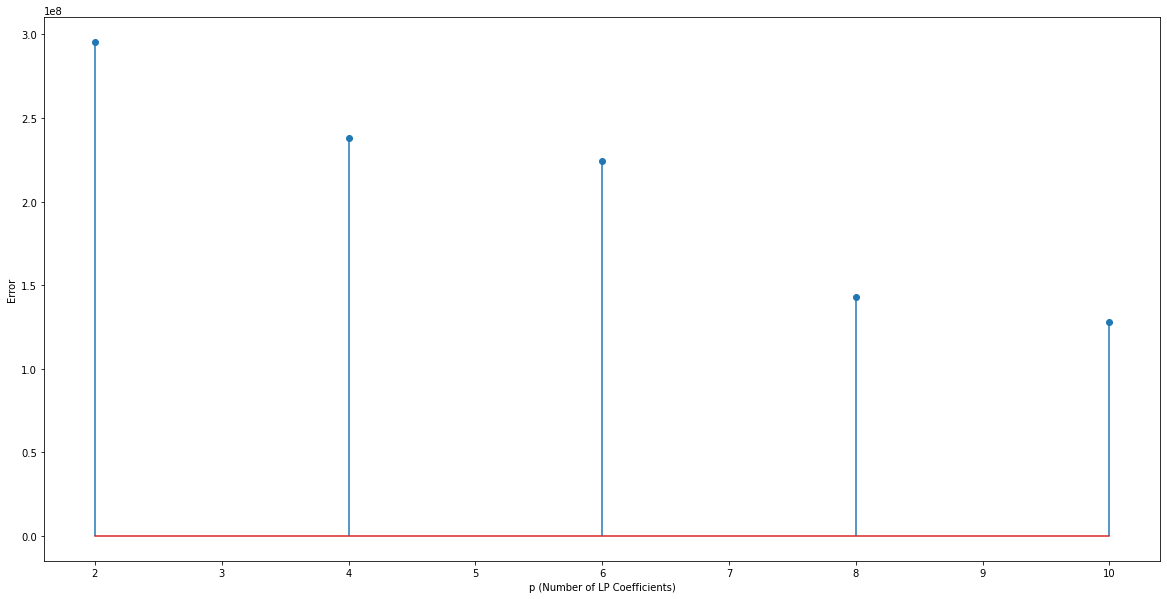

In [48]:
# Plotting the desired errors with respect to p
errors_desired = [errors[1], errors[3], errors[5], errors[7], errors[9]]
p = [2,4,6,8,10]

plt.figure(figsize=(20,10))
plt.stem(p, errors_desired, use_line_collection=True)
plt.xlabel('p (Number of LP Coefficients)')
plt.ylabel('Error')

#### Comments: 

#### <font color='dodgerblue'> The error keeps reducing as we increase the value of p, which was expected in the LP analysis

### 4. Show the pole-zero plots of the estimated all-pole filter for p=6,10; comment.

#### PZ Plot for p = 6

Helper function for Plotting the PZ Map

In [82]:
#
# Copyright (c) 2011 Christopher Felton
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.
#

# The following is derived from the slides presented by
# Alexander Kain for CS506/606 "Special Topics: Speech Signal Processing"
# CSLU / OHSU, Spring Term 2011.

import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import patches
from matplotlib.figure import Figure
from matplotlib import rcParams
    
def zplane(b,a,filename=None):
    """Plot the complex z-plane given a transfer function.
    """

    # get a figure/plot
    ax = plt.subplot(111)

    # create the unit circle
    uc = patches.Circle((0,0), radius=1, fill=False,
                        color='black', ls='dashed')
    ax.add_patch(uc)

    # The coefficients are less than 1, normalize the coeficients
    if np.max(b) > 1:
        kn = np.max(b)
        b = b/float(kn)
    else:
        kn = 1

    if np.max(a) > 1:
        kd = np.max(a)
        a = a/float(kd)
    else:
        kd = 1
        
    # Get the poles and zeros
    p = np.roots(a)
    z = np.roots(b)
    k = kn/float(kd)
    
    # Plot the zeros and set marker properties    
    t1 = plt.plot(z.real, z.imag, 'go', ms=10)
    plt.setp( t1, markersize=10.0, markeredgewidth=1.0,
              markeredgecolor='k', markerfacecolor='g')

    # Plot the poles and set marker properties
    t2 = plt.plot(p.real, p.imag, 'rx', ms=10)
    plt.setp( t2, markersize=12.0, markeredgewidth=3.0,
              markeredgecolor='r', markerfacecolor='r')

    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlabel('Im{z}', fontsize=10)
    ax.set_ylabel('Re{z}', fontsize='medium')

    # set the ticks
    r = 1.5; plt.axis('scaled'); plt.axis([-r, r, -r, r])
    ticks = [-1, -.5, .5, 1]; plt.xticks(ticks); plt.yticks(ticks);

    if filename is None:
        plt.show()

    else:
        plt.savefig(filename)
    

    return z, p, k

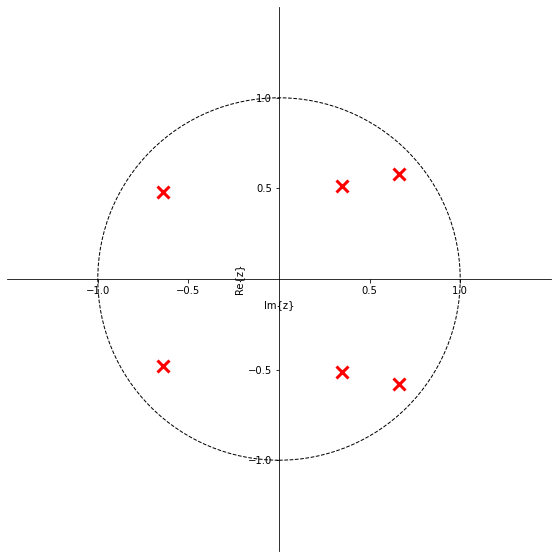

In [84]:
# The estimated all pole filter for p = 6
filter_coeffs = coeffs[5]
num = [1]
den = [1 , -filter_coeffs[0], -filter_coeffs[1], -filter_coeffs[2], -filter_coeffs[3], -filter_coeffs[4], -filter_coeffs[5]]

# Obtaining the transfer function from the numerator and denominator coefficients
transfer_function = control.tf(num,den)


# Plotting the PZmap using the obtained transfer function function
plt.figure(figsize = (20,10))
zeros, poles, _ = zplane(num,den)

In [85]:
print('The following are the poles of the all pole filter with p=6 : ')
for pole in poles:
  print(pole)

The following are the poles of the all pole filter with p=6 : 
(-0.6387618965945399+0.4787149516665391j)
(-0.6387618965945399-0.4787149516665391j)
(0.6600576007393908+0.5821776395128868j)
(0.6600576007393908-0.5821776395128868j)
(0.3459232647483863+0.5144124447090076j)
(0.3459232647483863-0.5144124447090076j)



#### Comments:

<font color='dodgerblue'> The following observations are inferred from the PZ Map:

* <font color='dodgerblue'> In the above pole-zero map for p = 6, we can observe that the number of poles are 6 with all of them in conjugate pairs. All the poles lie within the unit circle, thus the system in minimum phase. Thus, there will be less delay introduced by the system to an input signal. 


* <font color='dodgerblue'> There are three poles in $\omega$ $\in$ [0, $\pi$]. Two of those poles are close enough to the unit circle to show up as peaks in the power spectrum. Thus as we move from 0 to $\pi$, there will be 2 peaks in the power spectrum.


* <font color='dodgerblue'> As the distance of the second peak in 0 to $\frac{\pi}{2}$, is much larger from the unit circle, its effect is not expected to be dominant in the power spectrum of the output signal.

       

#### PZ Plot for p = 10

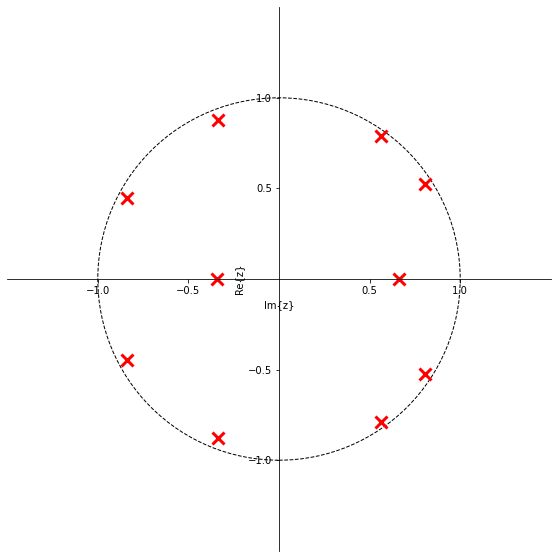

In [87]:
# The estimated all pole filter for p = 10
num = [1] # Numerator coefficients for TF

den = np.zeros(11)
den[0] = 1
den[1:] = -coeffs[9]  # Denominator coefficients for TF

# Obtaining the transfer function from the numerator and denominator coefficients
transfer_function = control.tf(num,den)

# Plotting the PZmap using the obtained transfer function function
plt.figure(figsize = (20,10))
zeros, poles, _ = zplane(num,den)

In [88]:
print('The following are the poles of the all pole filter with p=10 : ')
for pole in poles:
  print(pole)

The following are the poles of the all pole filter with p=10 : 
(0.5612374930754191+0.7897569352225988j)
(0.5612374930754191-0.7897569352225988j)
(0.804286828740379+0.5222438579930275j)
(0.804286828740379-0.5222438579930275j)
(0.6639861735554604+0j)
(-0.33557053955681193+0.8749661126854026j)
(-0.33557053955681193-0.8749661126854026j)
(-0.8364901877250032+0.44531614705452627j)
(-0.8364901877250032-0.44531614705452627j)
(-0.3417687006340657+0j)


#### Comments:

<font color='dodgerblue'> The following observations are inferred from the PZ Map:

* <font color='dodgerblue'> In the above pole-zero map for p = 10, we can observe that the number of poles are 10 with 8 of them in complex conjugate pairs and 2 real poles. We can also see that all the poles lie within the unit circle, thus the system in minimum phase as similar to the case in p=6.


* <font color='dodgerblue'> There are 4 poles in $\omega$ $\in$ [0, $\pi$].All of those poles are very close to the unit circle to show up as peaks in the power spectrum. Thus, we expect to see 4 peaks in the power spectrum.





### 5. Compute the gain and plot the LPC spectrum magnitude (i.e. the dB magnitude frequency response of the estimated all-pole filter) for each order "p".  Comment on the characteristics of the spectral envelope estimates. Comment on their shapes with reference to the short-time magnitude spectrum computed in part 2

In [89]:
# Computing all the coefficients and error signals for p= 10
coeffs, errors = levinson_durbin(windowed_signal, 10)

In [92]:
G = []
for p in range(0,10):
  sum = 0
  for j in range(0,p):
    sum = sum + coeffs[p][j]*autocorrelation(j, windowed_signal)
  g = np.sqrt(autocorrelation(0, windowed_signal) - sum)
  G.append(g)

In [93]:
# Getting the transfer functions corresponding to different LP values and their respective gains
transfer_functions = []
for i in range(len(G)):
  den = np.zeros(i+2)
  den[0] = 1
  den[1:i+2] = -coeffs[i][0:i+1]
  _,tf = sig.freqz([G[i]],den, worN=1000) # Computing 1000 point DFT for better resolution
  transfer_functions.append(tf)

In [94]:
# Getting the spectral envelope estimates using the DTFT
mag_spectrums = list(map(abs, transfer_functions))
mag_dB_spectrums = list(map(np.log, mag_spectrums))

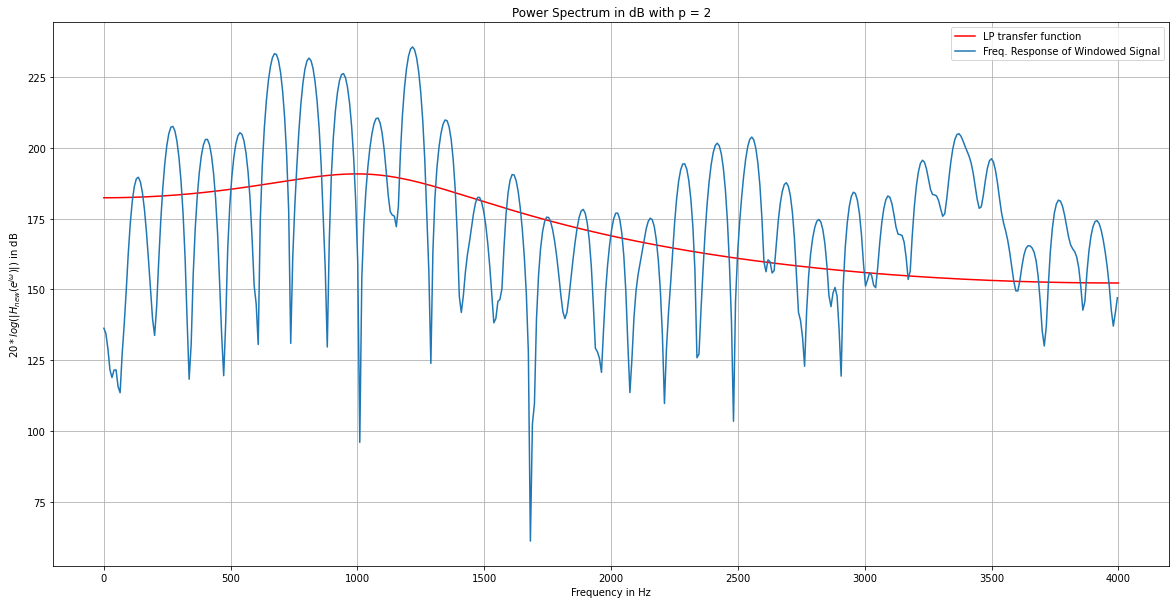

In [171]:
omega_windowed = np.linspace(0, 4000, 1000) # Plotting 100 points for better resolution
plt.figure(figsize = (20,10))
plt.plot(omega_windowed, 20*mag_dB_spectrums[1], '-r', label = 'LP transfer function')
plt.plot(frequency[0:500], 20*np.log(mag_win_sig_spectrum[0:500]), label = 'Freq. Response of Windowed Signal')
plt.xlabel('Frequency in Hz')
plt.ylabel('$20*log(|H_{new}(e^{j\omega})|)$ in dB')
plt.legend()
plt.title('Power Spectrum in dB with p = 2')
plt.grid()

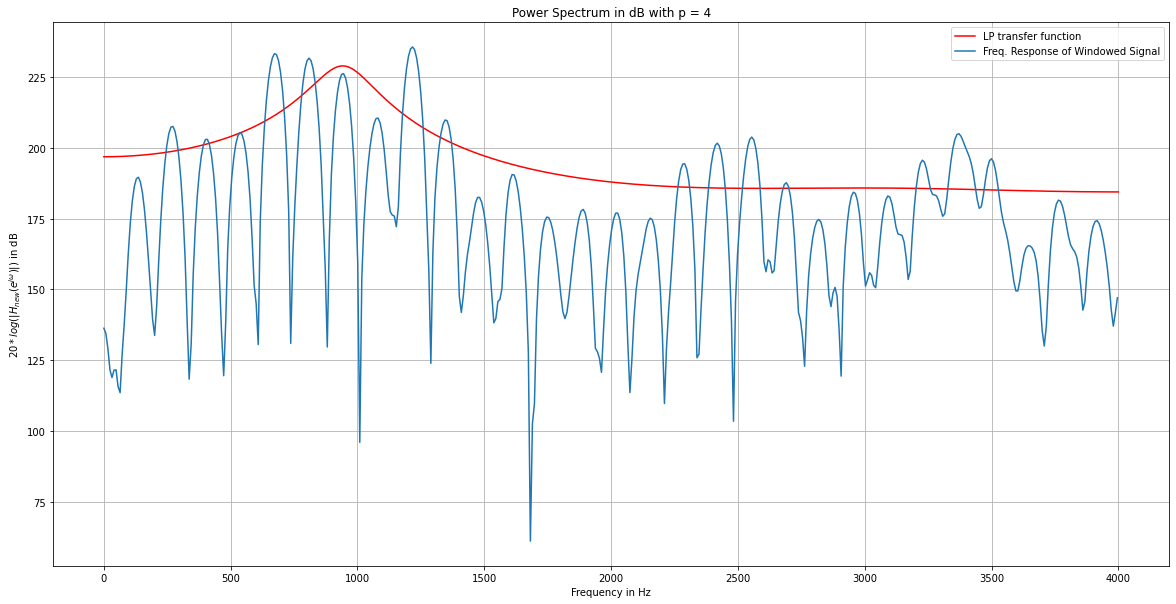

In [172]:
plt.figure(figsize = (20,10))
plt.plot(omega_windowed, 20*mag_dB_spectrums[3], '-r', label = 'LP transfer function')
plt.plot(frequency[0:500], 20*np.log(mag_win_sig_spectrum[0:500]), label = 'Freq. Response of Windowed Signal')
plt.xlabel('Frequency in Hz')
plt.ylabel('$20*log(|H_{new}(e^{j\omega})|)$ in dB')
plt.legend()
plt.title('Power Spectrum in dB with p = 4')
plt.grid()

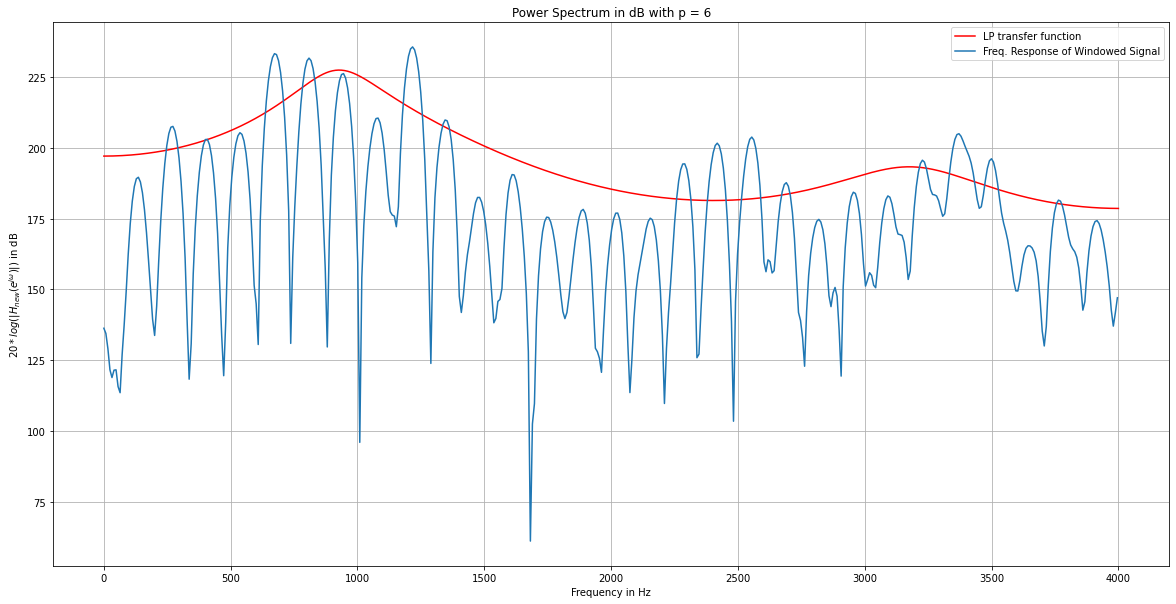

In [173]:
plt.figure(figsize = (20,10))
plt.plot(omega_windowed, 20*mag_dB_spectrums[5], '-r', label = 'LP transfer function')
plt.plot(frequency[0:500], 20*np.log(mag_win_sig_spectrum[0:500]), label = 'Freq. Response of Windowed Signal')
plt.xlabel('Frequency in Hz')
plt.ylabel('$20*log(|H_{new}(e^{j\omega})|)$ in dB')
plt.legend()
plt.title('Power Spectrum in dB with p = 6')
plt.grid()

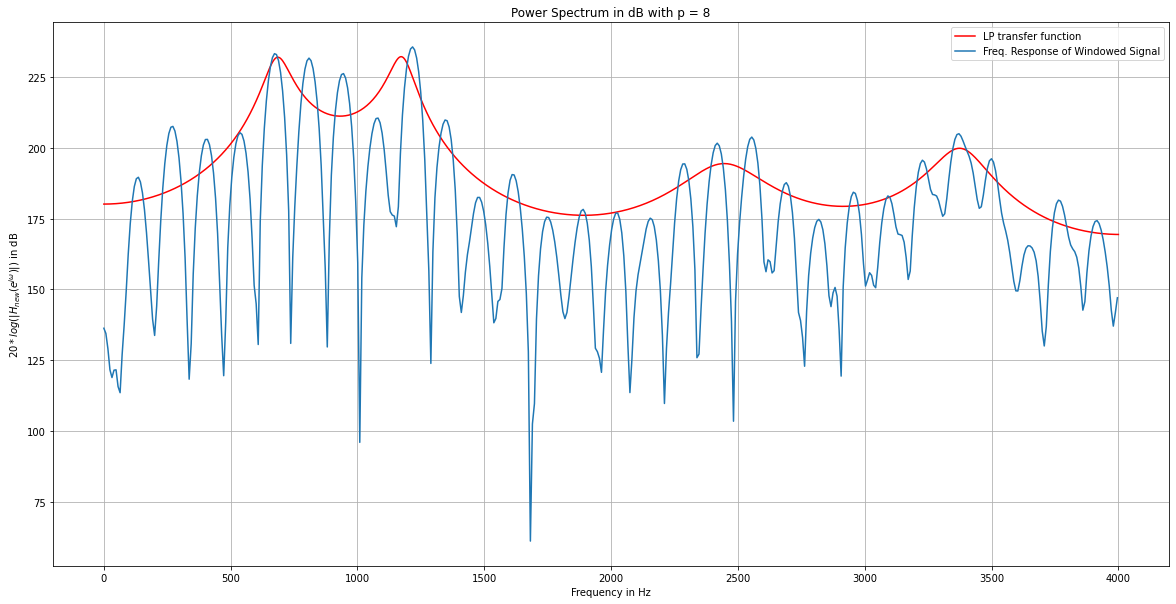

In [174]:
plt.figure(figsize = (20,10))
plt.plot(omega_windowed, 20*mag_dB_spectrums[7], '-r', label = 'LP transfer function')
plt.plot(frequency[0:500], 20*np.log(mag_win_sig_spectrum[0:500]), label = 'Freq. Response of Windowed Signal')
plt.xlabel('Frequency in Hz')
plt.ylabel('$20*log(|H_{new}(e^{j\omega})|)$ in dB')
plt.legend()
plt.title('Power Spectrum in dB with p = 8')
plt.grid()

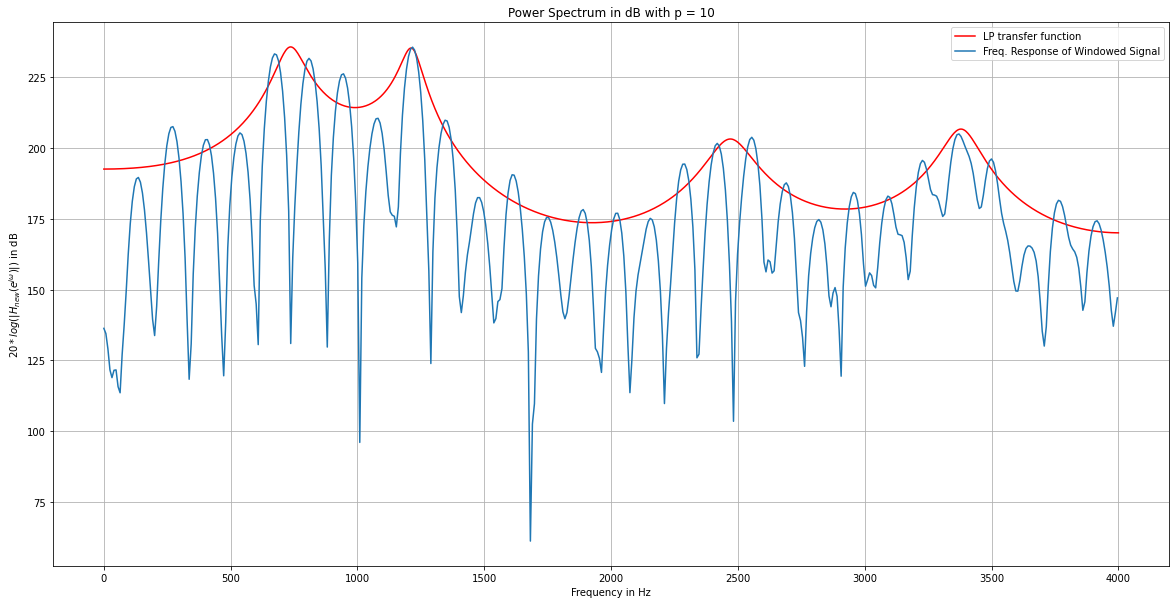

In [175]:
plt.figure(figsize = (20,10))
plt.plot(omega_windowed, 20*mag_dB_spectrums[9], '-r', label = 'LP transfer function')
plt.plot(frequency[0:500], 20*np.log(mag_win_sig_spectrum[0:500]), label = 'Freq. Response of Windowed Signal')
plt.xlabel('Frequency in Hz')
plt.ylabel('$20*log(|H_{new}(e^{j\omega})|)$ in dB')
plt.legend()
plt.title('Power Spectrum in dB with p = 10')
plt.grid()

#### Comments:

<font color='dodgerblue'> The following observations have been inferred from the Power Spectrum comparison (Magnitude in dB) between the windowed signal and the filter transfer function corresponding to different p values:

* <font color='dodgerblue'> As p increases, we can see that the spectrum corresponding to the filter transfer function is able to match the peaks better.


* <font color='dodgerblue'> There are 4 poles in $\omega$ $\in$ [0, $\pi$]. All of those poles are very close to the unit circle to show up as peaks in the power spectrum. Thus, we expect to see 4 peaks in the power spectrum.


* <font color='dodgerblue'> As we have seen in the pole zero plot for p=6 and p=10, our expected number of peaks estimated by the LP transfer function match with the number of peaks in the spectrum.



### 6. Based on the 10th-order LP coefficients, carry out the inverse filtering of the /a/ vowel segment to obtain the residual error signal. Can you measure the pitch period of the voiced sound from the residual waveform? Use the acf to detect the pitch. Compare the acf plots of the original speech and residual signals.  

In [100]:
# Computing all the coefficients and error signals for p= 10
coeffs, errors = levinson_durbin(windowed_signal, 10)

In [101]:
# Inverse transfer function coefficients
num = np.zeros(11)
num[0] = 1
num[1:11] = -coeffs[9][0:10]

error_signal = sig.lfilter(num,[G[9]],windowed_signal)

Text(0, 0.5, '$e[n]$')

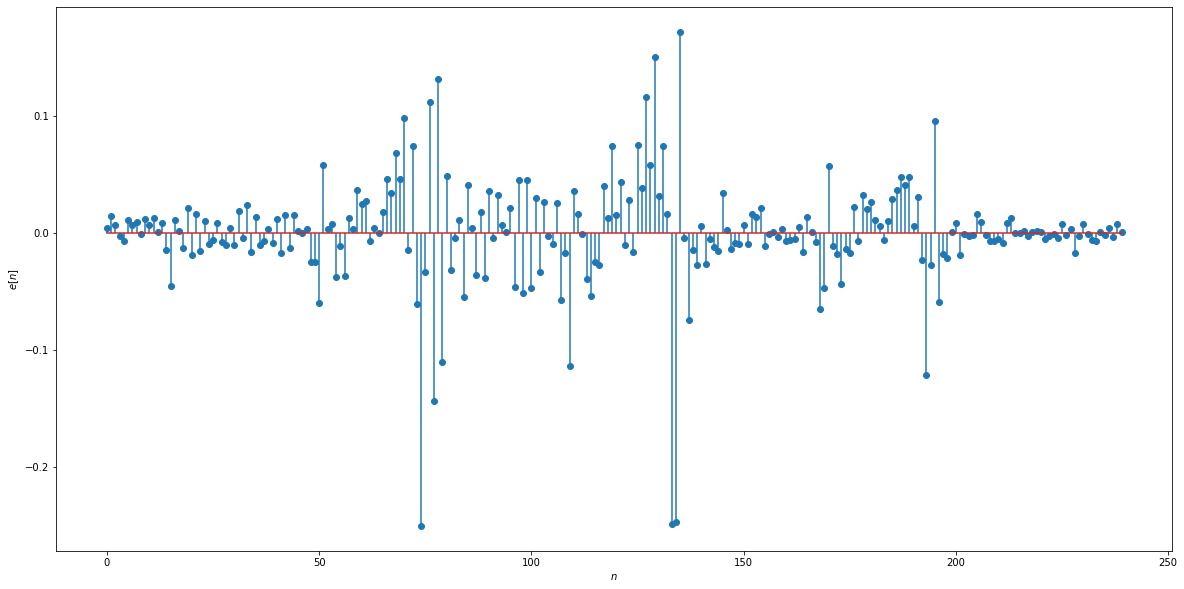

In [102]:
plt.figure(figsize = (20,10))
plt.stem(error_signal, use_line_collection=True)
plt.xlabel('$n$')
plt.ylabel('$e[n]$')

#### Getting the pitch period from the ACF of the speech signal

In [133]:
# Getting the ACFs of the error/residual signal.
acfs = []
for i in range(0,240):
  acfs.append(autocorrelation(i,error_signal))

Text(0, 0.5, '$acfs[n]$')

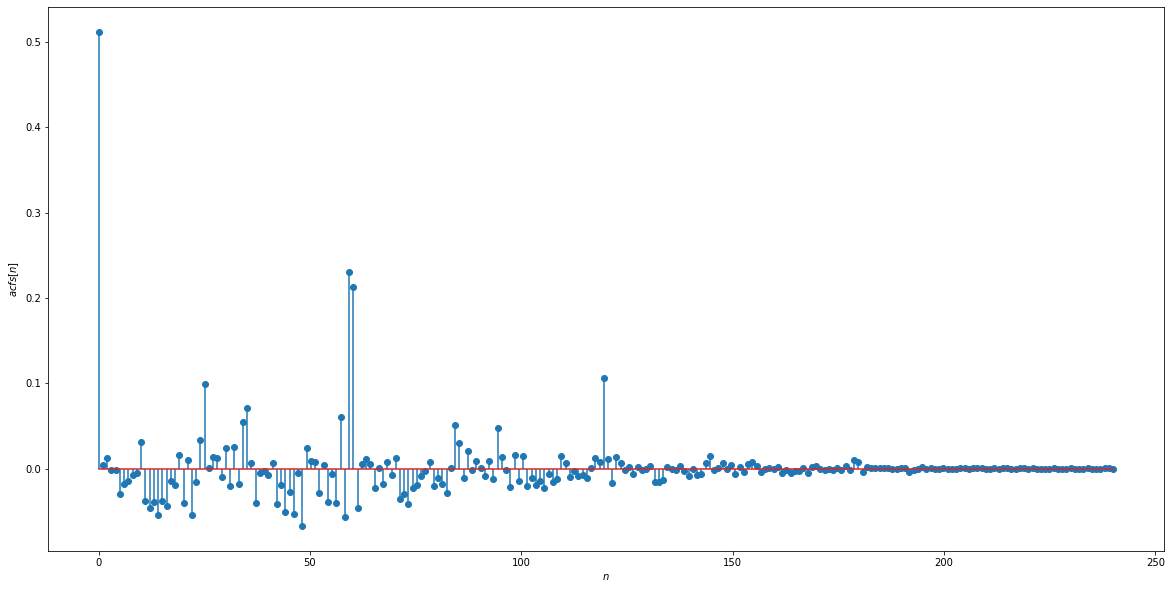

In [155]:
n = np.linspace(0,240,240)
plt.figure(figsize = (20,10))
plt.stem(n, acfs, use_line_collection=True)
plt.xlabel('$n$')
plt.ylabel('$acfs[n]$')

In ACF, the period is obtained by the first maxima after the maxima at k = 0.

From the diagram we can say that, the 

In [119]:
def get_pitch_period(acf):
  return np.argmax(acf[2:]) + 2

In [120]:
pitch = get_pitch_period(acfs)

In [121]:
print("The pitch of the input audio signal is",pitch)

The pitch of the input audio signal is 59


#### Comparing the ACFs of the original windowed signal with the residual signal

In [159]:
# Getting the scaled ACFs of the original signal.
acfs_original = []
for i in range(0,240):
  acfs_original.append(autocorrelation(i,windowed_signal))

Text(0, 0.5, 'acfs_original')

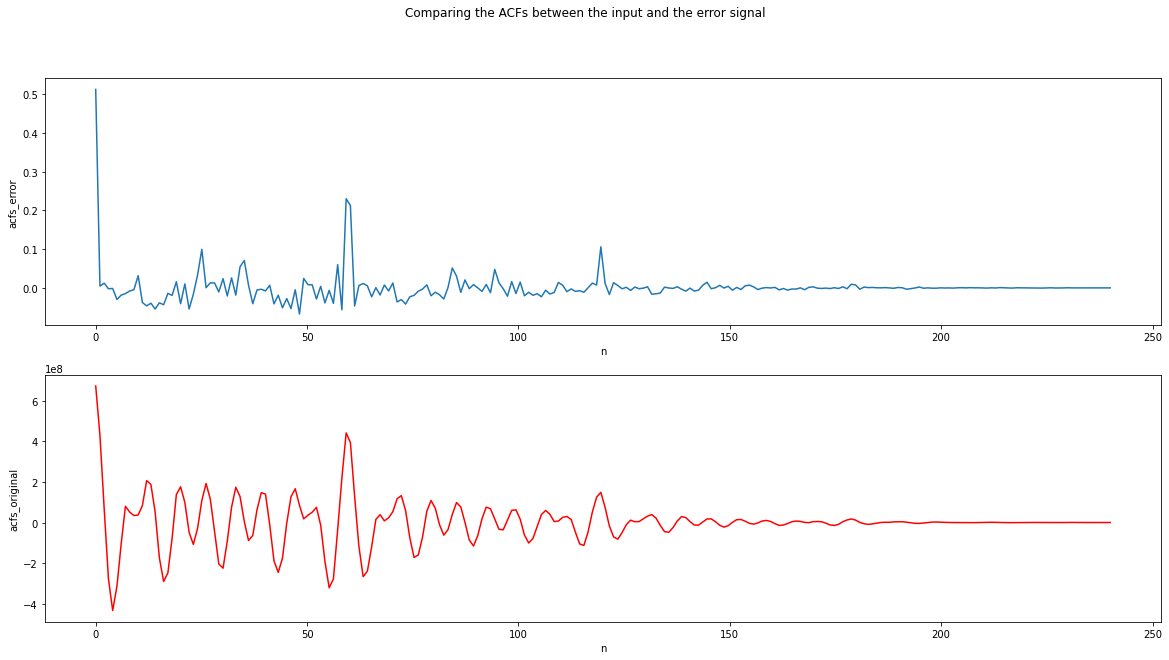

In [163]:
plt.figure(figsize = (20,10))
plt.suptitle('Comparing the ACFs between the input and the error signal')
plt.subplot(2,1,1)
plt.plot(n, acfs)
plt.xlabel('n')
plt.ylabel('acfs_error')

plt.subplot(2,1,2)
plt.plot(n, acfs_original,'-r')
plt.xlabel('n')
plt.ylabel('acfs_original')


#### Comments:

<font color='dodgerblue'> The following observations are inferred from the above comparision:

* <font color='dodgerblue'> The waveform shape of the error ACF and the input ACF are approximately similar, the only major difference is in the scale values.


* <font color='dodgerblue'> The location of peaks in the error ACF and the input ACF are exactly the same. Thus we can use either of the signal to compute the pitch.


* <font color='dodgerblue'> Since the ACF plots of both the original and the error signal are very similar, thus we can estimate the signal properties from the error signal itself  using LP analysis. We can also use LP synthesis to recover the original signal from the error signal as well. Also, the error signal has rather lesser amplitude than the original signal, thus it is easier to transmit in lesser number of bits across a communication channel.

### 7.(Optional for bonus marks)  

### LP  re-synthesis:  We analysed a natural  speech sound /a/ above.  Using  a  suitable  set  of  parameter  estimates  as  obtained  there,  we  wish  to reconstruct the sound.  

### That is, use the best estimated LP filter with an ideal impulse train of the estimated pitch period as source excitation.  Carry out de-emphasis on the output waveform. Set the duration of the synthesized sound to be 300 ms at 8 kHz sampling frequency and view the waveform as well as listen to your created sound

In [109]:
# sequence with 8000 samples
n = np.linspace(0,2400,2400)

def impulse(n,period):
  arr = []
  for i in range(len(n)):
    if(i%period == 0):
      arr.append(1)
    else:
      arr.append(0)
  return arr

In [110]:
impulse_train = impulse(n,59)

<StemContainer object of 3 artists>

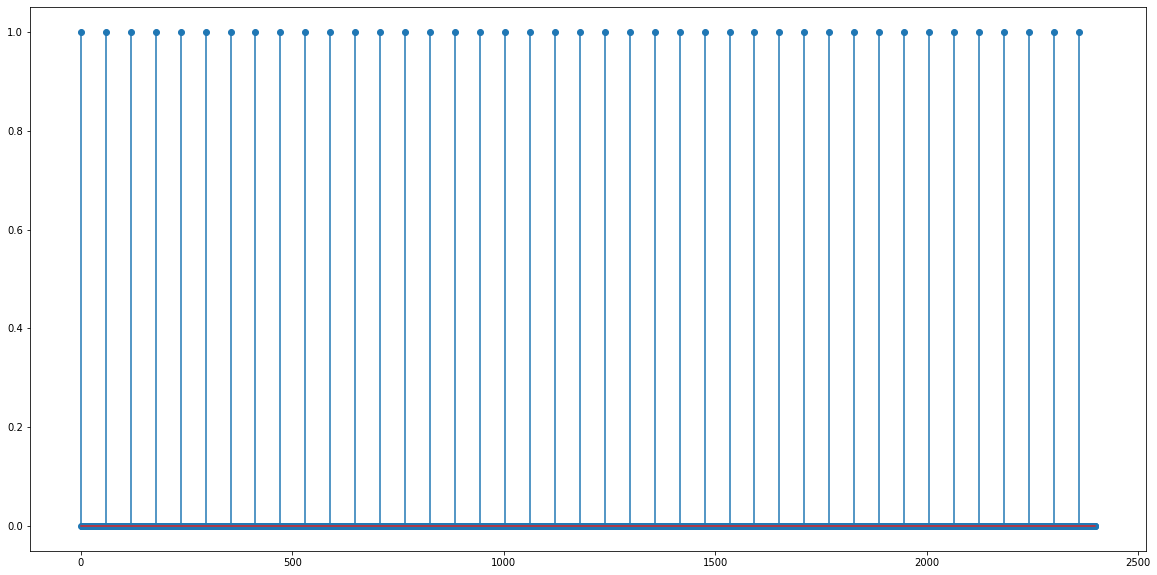

In [111]:
plt.figure(figsize = (20,10))
plt.stem(impulse_train, use_line_collection=True)

In [112]:
# Best estimated filter response

# Transfer function
den = np.zeros(11)
den[0] = 1
den[1:11] = -coeffs[9][0:10]

estimated_signal = sig.lfilter([G[9]],den,impulse_train)

# Applying De-emphasis
alpha = 0.95
a = [1.0, -alpha]
b = [1.0]

estimated_de_emph = sig.lfilter(b,a,estimated_signal)

Text(0.5, 1.0, 'Plotting the estimated signal only for 300 samples')

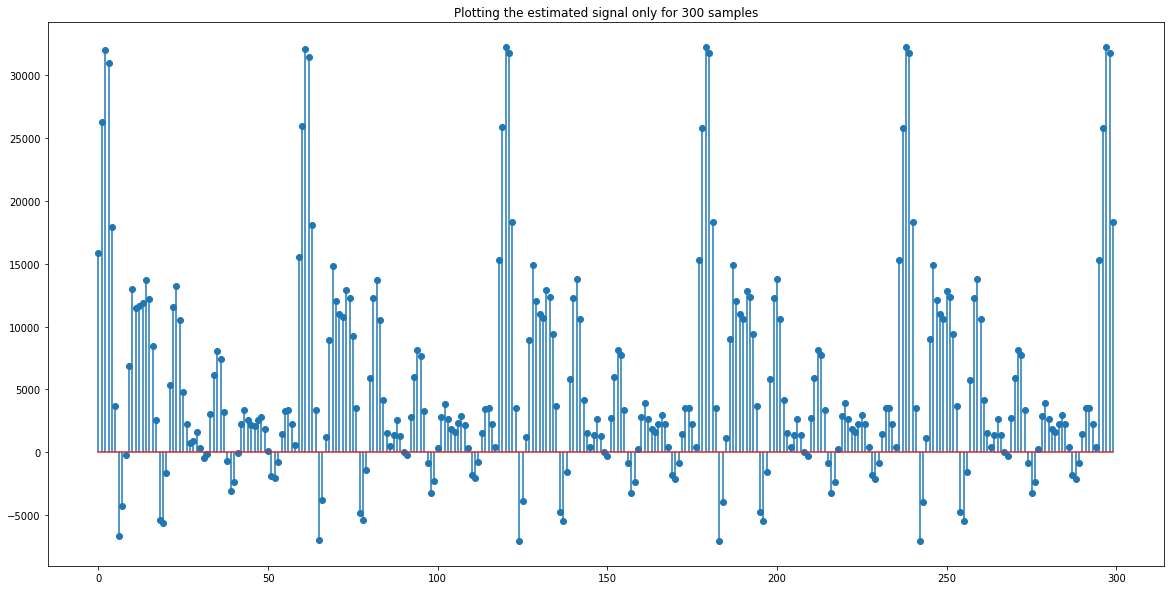

In [113]:
plt.figure(figsize = (20,10))
plt.stem(estimated_de_emph[0:300], use_line_collection=True)
plt.title('Plotting the estimated signal only for 300 samples')

In [114]:
estimated_filename = '/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 3/aa_estimated.wav'
write(estimated_filename, 8000, estimated_de_emph.astype('int16'))

# Playing the audio
IPython.display.Audio(estimated_filename)

### Comment on the similarity with the original sound. Try out voice modification using this analysis-synthesis method (e.g. change the voice pitch). 

#### <font color='dodgerblue'> Upon comparision with the original sound, the sound uttered completely matches the one which was sent as input. Still, the sound seems artificial and lacks the way how we humans voice sounds. The sound synthesised also sounds longer than the original sound.

#### <font color='dodgerblue'> There is also a little nasal content in the sound, adding to the robot like features.

# Generating the HTML file

In [177]:
%cd '/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 3'

/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 3


In [178]:
!jupyter nbconvert --to html '/content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 3/Assignment_3.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 3/Assignment_3.ipynb to html
[NbConvertApp] Writing 1742224 bytes to /content/drive/MyDrive/Academics/Semester 1/Speech Processing/Assignment 3/Assignment_3.html
